# Introduction
In this project, I create a table of with information about metropolitan areas in the United States. For simplicity, they are called just "cities". The variables are:
- Population,
- Average Rental Price,
- Median Rental Price,
- Unemploument Rate,
- Per Capita Income,
- Air Quality,
- Walk, Transit, and Bike Scores, 
- Cost of Living,
- Price Parity,
- Median Commute Time.

After I find the data in open sources, I clean it if needed and load one by one with a simple custom function. Along the way, I explain the methodology for each metrics and what does it mean. 

The second part of the project is exploratory data analysis.

<b> Goals</b>
    
<b>    Methods</b>
    
    
<b>    Expections </b>

# Load Data
In this part we are creating a DataFrame with ten columns mentioned above, explain the meaning and methodology behind each one.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import scipy.stats as stats

Create an empty DataFrame and define a function to append new columns to it later.

In [2]:
cities = pd.DataFrame(columns=['City', 'State'])

def merge_frames(new_df, method='left', print_ten=False):
    df = pd.merge(cities, new_df, on=['City', 'State'], how=method)
    if print_ten == True:
        print(df.head(10))
    return df

##### First four columns

### Population
Metropolitan Area Population in 2020. Data from Census, retrieved from [citypopulation.de](https://citypopulation.de/) and preprocessed by myself in Excel.

In [3]:
pop = pd.read_csv('Data/population.csv')
cities = merge_frames(pop, method='right', print_ten=True)

           City State  Population
0      New York    NY  20140470.0
1   Los Angeles    CA  13200998.0
2       Chicago    IL   9618502.0
3        Dallas    TX   7637387.0
4       Houston    TX   7122240.0
5    Washington    DC   6385162.0
6  Philadelphia    PA   6245051.0
7         Miami    FL   6138333.0
8       Atlanta    GA   6089815.0
9        Boston    MA   4941632.0


### Average Rent
Average rent proces for a one room flat. Data from [Zillow](https://www.zillow.com/research/data/).\
It calculated the monthly means by regressing changes in rent prices on the change in time between two transactions and adjusting the weights based on the prevalence of the units being rented. The index is then smoothed and dollar-denominated to make it more interpretable.

In [4]:
# Load data with rent means, assign columns names
cols = ['RegionName', 'StateName', '2023-01-31']
new_cols = ['City', 'State', 'AvgRent']
rent_means = pd.read_csv('Data/rent_mean_2023.csv', usecols=cols)
rent_means.columns = new_cols

In [5]:
# Drop NaN values, change data types
rent_means = rent_means.dropna(how='any')
rent_means['City'] = rent_means['City']
rent_means.loc[:, 'AvgRent'] = rent_means['AvgRent'].apply(lambda x: int(x))

In [6]:
# Append the average rent variable to the main DataFrame with a custom function
cities = merge_frames(rent_means, method='inner', print_ten=True)

           City State  Population  AvgRent
0      New York    NY  20140470.0     3272
1   Los Angeles    CA  13200998.0     2857
2       Chicago    IL   9618502.0     1975
3        Dallas    TX   7637387.0     1754
4       Houston    TX   7122240.0     1620
5    Washington    DC   6385162.0     2421
6  Philadelphia    PA   6245051.0     1663
7         Miami    FL   6138333.0     3201
8       Atlanta    GA   6089815.0     1991
9        Boston    MA   4941632.0     3419


### Median Rent
Median prices for a one room flat. Data from [HUD User](https://www.countyhealthrankings.org/explore-health-rankings/rankings-data-documentation).\
The 50th percentile rent estimates are based on the most recent data available from the [American Community Survey](https://www.census.gov/data/developers/data-sets/acs-5year.html), which is conducted by the U.S. Census Bureau. They are calculated using a model that takes into account geography, unit size, and contract type (e.g. rent-controlled vs market rate).

In [7]:
# Load data with rent means, assign columns names, specify delimiter
cols = ['hud_areaname', 'rent_50_1']
new_cols = ['City', 'MedianRent']
rent_medians = pd.read_csv('Data/rent_median_2023.tsv', usecols=cols, delimiter='\t')
rent_medians.columns = new_cols

In [8]:
# Create a State column and clean the city names
rent_medians['State'] = rent_medians['City'].apply(lambda x: x.split(',')[-1].strip()[:2])
rent_medians['City'] = rent_medians['City'].apply(lambda x: x.split(',')[0].split('-')[0])

# Remove comma from MedianRent and turn it into integer
def remove_comma(x):
    if ',' in x:
        return x.replace(',', '')
    return x
rent_medians['MedianRent'] = rent_medians['MedianRent'].apply(lambda x: int(remove_comma(x)))

rent_medians.head(10)

,City,MedianRent,State
0,San Francisco,3000,CA
1,San Jose,2763,CA
2,Santa Cruz,2602,CA
3,Santa Maria,2490,CA
4,Boston,2368,MA
5,Salinas,2324,CA
6,New York,2323,NY
7,Stamford,2321,CT
8,Santa Ana,2274,CA
9,Dukes County,2200,MA


In [9]:
cities = merge_frames(rent_medians, print_ten=True)

           City State  Population  AvgRent  MedianRent
0      New York    NY  20140470.0     3272      2323.0
1   Los Angeles    CA  13200998.0     2857      1925.0
2       Chicago    IL   9618502.0     1975      1364.0
3        Dallas    TX   7637387.0     1754      1440.0
4       Houston    TX   7122240.0     1620      1216.0
5    Washington    DC   6385162.0     2421      1740.0
6  Philadelphia    PA   6245051.0     1663      1314.0
7         Miami    FL   6138333.0     3201      1670.0
8       Atlanta    GA   6089815.0     1991      1489.0
9        Boston    MA   4941632.0     3419      2368.0


### Unemployment
Unemployment Rates for Metropolitan Areas in January 2023, Not Seasonally Adjusted. Data from [U.S. Bureau of Labor Statistics](https://www.bls.gov/web/metro/laummtrk.htm#laummtrk.f.p).\
The unemployment rate is calculated as the number of unemployed individuals divided by the total labor force, which is the sum of employed and unemployed individuals. The unemployed are defined as individuals who are not currently employed but are available for work and have actively sought employment in the past four weeks. The data is collected by a monthly survey of households called the Current Population Survey. The survey is conducted by the U.S. Census Bureau and is designed to be representative of the civilian noninstitutional population aged 16 years and over.

In [10]:
# The data from the file "unemp.txt" requires some cleaning, 
# as values are split by not one but three delimiters (tabs, commas, and newlines).
temp_list1 = []
temp_list2 = []
unemp_list = []

# Open text file with unemployment rate data. 
# This file is broken, because every first value has a newspace character and every second has a trailing tab.
with open("Data/unemp.txt", 'r') as unemp:
    for i, line in enumerate(unemp.readlines()):
        # If line is even, add to the first temp_list
        if i % 2 == 0:
            # Clean the line and split cities and states
            this_line = line.rstrip(' \n').split(', ')
            # Leave only one city from metropolitan area and one state
            city_state = [this_line[j].split('-')[0] for j in range(len(this_line))]            
            temp_list1.append(city_state)
        # If line is odd, add to the second temp_list
        else:
            # We need onnly the rate variable
            temp_list2.append(line.split('\t')[0])

# Create a final list from two temporary ones
for i in range(len(temp_list1)):
    unemp_list.append(temp_list1[i] + [temp_list2[i]])
del temp_list1, temp_list2

In [11]:
# Create an unemployment DF
unemp_df = pd.DataFrame(unemp_list, columns=['City', 'State', 'UnempRate'])
print(unemp_df.head(10))

          City State UnempRate
0      Madison    WI       1.6
1     Columbia    MO       1.7
2      Decatur    AL       1.8
3  Fond du Lac    WI       1.8
4   Huntsville    AL       1.8
5        Logan    UT       1.8
6    Sheboygan    WI       1.8
7         Ames    IA       1.9
8     Appleton    WI       1.9
9     Columbus    IN       1.9


In [12]:
cities = merge_frames(unemp_df)

#### Last six columns
The next set of variables comes in a more tidy format and are simply appended to the main DataFrame. However, some of them were pre-processed by me in Excel for time efficiency. In most cases, it was just a matter of splitting columns by a certain delimiter and deleting unnecessary commas and periods in numeric values.


### Average Income
Per Capita Income by Metropolitan Area in 2021.Data from [U.S. Bureau of Economic Analyses](https://www.bea.gov/data/income-saving/personal-income-county-metro-and-other-areas) (preprocessed by myself in Excel).\
Per capita income is calculated by dividing population into personal income. Total personal income includes all income received by all people in the area, including wages and salaries, proprietor's income, rental income, and government transfer payments. The population estimates tight with data from the U.S. Census Bureau.

In [13]:
income_personal = pd.read_csv('Data/income_personal.csv')
cities = merge_frames(income_personal)

### Air Quality
Air Quality Index (AQI). Data from [U.S. Environmental Protection Agency](aqs.epa.gov).\
The AQI is based on the concentrations of five major air pollutants regulated by the Clean Air Act: ground-level ozone, particle pollution, carbon monoxide, sulfur dioxide, and nitrogen dioxide.
The AQI is calculated based on the highest concentration of these pollutants in a given area over a certain period of time, and then scaled to a value between 0 and 500.\
AQI lower than 50 is considered good, from 51 to 100 – moderate. When the AQI value is higher than 100, the air quality is unhealthy: at first for certain sensitive groups of people, and then for everyone as the AQI value gets higher and higher. The index is calculated 

In [14]:
air = pd.read_csv('Data/aqi.csv')
cities = merge_frames(air)

### Walkability, Transit, and Bike Scores
Data from [Walk Score](https://www.walkscore.com/).

Walk Score measures the walkability of an area. For each address, points are awarded based on the distance to amenities in each category. Amenities within a 5-minute walk receive maximum points. A decay function is used to give points to more distant amenities, with no points awarded after a 30 minute walk.

Bike Score measures whether a location is good for biking. It's calculated by measuring bike infrastructure (lanes, trails, etc.), hills, destinations and road connectivity, and the number of bike commuters.

Each score uses the same metric to translate itself to description. Example with Walk Score:
- 90–100	Daily errands do not require a car (Walker's Paradise)
- 70–89	    Most errands can be accomplished on foot.
- 50–69	    Some errands can be accomplished on foot.
- 25–49	    Most errands require a car (car-dependent).
- 0–24	    Almost all errands require a car (car-dependent).

In [15]:
walkability = pd.read_csv('Data/walkscore.csv')
cities = merge_frames(walkability)

### Transit Score
Data from [AllTransit](https://alltransit.cnt.org/rankings/).

Transit Score measures access to public transit. The Performance Score by AllTransit takes into account connections to other routes, jobs within a 30-minute transit commute, and the number of workers who use transit to get to work. It measures the performance on a scale of 0 to 10.


In [16]:
transit_score = pd.read_csv('Data/transit_score.csv')
cities = merge_frames(transit_score, print_ten=True)

           City State  Population  AvgRent  MedianRent UnempRate  AvgIncome  \
0      New York    NY  20140470.0     3272      2323.0       3.8    85136.0   
1   Los Angeles    CA  13200998.0     2857      1925.0       3.9    75821.0   
2       Chicago    IL   9618502.0     1975      1364.0       4.2    71992.0   
3        Dallas    TX   7637387.0     1754      1440.0       3.2    66727.0   
4       Houston    TX   7122240.0     1620      1216.0       3.9    64837.0   
5    Washington    DC   6385162.0     2421      1740.0       2.8    80822.0   
6  Philadelphia    PA   6245051.0     1663      1314.0       3.4    72379.0   
7         Miami    FL   6138333.0     3201      1670.0       1.9    73522.0   
8       Atlanta    GA   6089815.0     1991      1489.0       2.6    63219.0   
9        Boston    MA   4941632.0     3419      2368.0       2.9    92290.0   

   MedianAQI  WalkScore  BikeScore  TransitScore  
0       50.0       88.0       69.3           6.9  
1       70.0       68.6     

### Cost of Living Index and Price Parities
Data from [AdvisorSmith](https://advisorsmith.com/data/coli/compare/abilene-tx-vs-new-york-ny/) and [Bureau of Economic Analysis](https://apps.bea.gov/)(BEA).

The cost of living was determined based on six major categories of expenses: food, housing, utilities, transportation, healthcare, and discretionary spending. The index is constructed to normalize the average cost of living in the United States to 100. The percentage weight allocated to each category of expense was determined based upon the average U.S. household budget, based on the Consumer Expenditure Surveys  (not to confuse with Current Population Survey used for unemployment rate).

A Regional price parities (RPPs) is a weighted average of the price level of goods and services for the average consumer in one geographic region compared to all other regions in the United States. The RPP for all the regions is 100 (e.g. price parity of 114.58 in New York means that prices in New York on average 14.58% higher than the U.S. average). First, BEA collects and organizes price data. Then it compares prices across regions (this is done by calculating the relative price levels for each region, using the national average price level as a benchmark). Lastly, it calculates the RPP by using the relative price levels to adjust for the differences in the cost of living across regions.

In [17]:
cost_of_living = pd.read_csv('Data/cost_of_living_index.csv')
rpp = pd.read_csv('Data/price_parities.csv')

In [18]:
cities = merge_frames(cost_of_living)
cities = merge_frames(rpp)

### Median Travel Time to Work
Data from U.S. Census, preprocessed by me in Excel.\
Commute time is collected by American Community Survey (ACS – the same one that was used to collect median rental prices). The ACS asks respondents to report the total number of minutes it usually takes them to travel from home to work. The median is then calculated based on the responses of all workers in a metropolitan area. More about the methodology [here](https://www.census.gov/programs-surveys/acs/methodology/design-and-methodology.html).

##### Getting the data
I had problems downloading the file from the Census website, so I manually copied and pasted the values in Excel. But it was pasted all in one column – with commute values in every other row. In order to fix that, I:
1. Moved the time values to another column with `=IF(ISEVEN(ROW(A1)),A1,"")`,
![Even Rows](Media/commute1.png)
2. Moved the metro values to the third column with `=IF(ISODD(ROW(A1)),A1,"")`,
3. Replaced these formulas with values and deleted the original broken column,
![Two Columns](Media/commute2.png)
4. Moved the A column up by one cell,
5. Filtered out the blank cells,
6. Dropped duplicates,
7. Split the geographical colummn by City and State,
8. Deleted the second and third towns in the names of metropolitan areas.

In [19]:
commute = pd.read_csv('Data/commute.csv')
cities = merge_frames(commute)

### Categorical Variables and State Names
Lastly, we need to add two categorical variables for the future analysis, namely:
- Region – for that I'll apply the South, Midwest, Northeast, West division used by the Census;
- Size rank – whether a city is considered big, small or in between.
Also, I would like to change two-letter state abbreviations to full names, because it looks nicer.


First, I ask ChatGPT to generate two dictionaries. One with two-letter state names as keys and full names as values and one with regions as keys and full names as values.\
Then I'll change the DataFrame using these dictionaries.

Region Category

In [20]:
# Import generated dictionaries
from state_dicts import state_names, us_regions

# Create a new list by matching values from the State column with state_names dictionary
state_list = list(cities.State)
new_state_list = [state_names[state_list[i]] for i in range(len(state_list))]
# Change values in the State column
cities['State'] = new_state_list

# Create a new column with region information by iterating through us_region dictionary and the State column, and matching the values
region_list = [next(key for key, val in us_regions.items() if x in val) for x in cities['State']]
cities['Region'] = region_list

Size Category\
There is no single definition for what constitutes a large, mid-sized or small metropolitan area. The definition varies depending on the context. Given the data, in the scope of this project the size of a metropolitan area is defined like this:
- Large — over one million people,
- Mid-sized — over 250 thousand and less than one million people,
- Small — less than 250 thousand people.

In [21]:
cities['Size'] = pd.cut(cities['Population'], bins=[0, 250000, 1000000, np.inf], labels=['Small', 'Mid-Sized', 'Large'])

In [22]:
# Rearrange the columns
cols = list(cities.columns) 
cities = cities[cols[:2] + cols[-2:] + cols[2:7] + cols[11:14] + cols[7:11]]

In [23]:
# Final version of the DataFrame before cleaning
cities.sample(5)

,City,State,Region,Size,Population,AvgRent,MedianRent,UnempRate,AvgIncome,CostOfLiving,PriceParity,CommuteTime,MedianAQI,WalkScore,BikeScore,TransitScore
374,Findlay,Ohio,Midwest,Small,74920.0,1265,NaN,NaN,NaN,91.1,NaN,NaN,NaN,NaN,NaN,NaN
281,Wheeling,West Virginia,South,Small,139513.0,822,694.0,4.2,50716.0,84.1,89.27,22.8,38.0,NaN,NaN,1.1
137,Trenton,New Jersey,Northeast,Mid-Sized,387340.0,2042,1439.0,2.5,77911.0,104.3,101.89,28.7,42.0,NaN,NaN,4.6
266,Dothan,Alabama,South,Small,151007.0,1450,666.0,2.2,49343.0,86.3,86.20,NaN,NaN,NaN,NaN,0.0
358,Bloomsburg,Pennsylvania,Northeast,Small,82863.0,1116,NaN,3.6,53309.0,93.2,89.78,21.0,NaN,NaN,NaN,0.0


# Clean Data

### Check for null values
First, find the non-standard missing values – ones that are undetectable by pandas because they don't look like NaN.\
For that, we loop through the rows of numeric columns and try convert values to int. If it's not possible then it's missing data.


In [24]:
# Select only numeric columns
cols_to_loop = cities.columns[4:]

# Dictionary to store all non-standard missing values and their amount
missing_dict = dict()

# Loop though each row
for i, row in cities.iterrows():
    # And then though each column
    for col in cols_to_loop:
        # Try convert values of the original DF to int
        try:
            cities.at[i, col] = float(cities.at[i, col])

        # If it's not possible then it's missing data
        except ValueError:
            # If a new string encountered, add it to the dictionary, else update the count
            if row[col] in missing_dict:
                missing_dict[row[col]] += 1
            else:
                missing_dict[row[col]] = 1

            # Replace this string with NaN
            cities.at[i, col] = np.nan

missing_dict

{}

### Drop Rows with Lots of NaN Values
Our table has too many missing values for a simple reason that each CSV we loaded had different set of cities. There are 67 cities out of 456 with all the rows filled.

In [25]:
# Number of cities with all the rows filled
cities.loc[cities.isna().sum(axis=1) == 0, 'City'].count()

73

We're gonna delete cities with more than half of the variables missing. All of them are quite small with only a dozen of metro areas having a population of more than 100,000.

In [26]:
dropped_cities = (cities.isna().sum(axis=1) >= 6)
cities = cities.loc[~dropped_cities].reset_index(drop=True)

### Check If All the Data Types Are Correct

In [27]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   City          344 non-null    object  
 1   State         344 non-null    object  
 2   Region        344 non-null    object  
 3   Size          344 non-null    category
 4   Population    344 non-null    float64 
 5   AvgRent       344 non-null    int64   
 6   MedianRent    338 non-null    float64 
 7   UnempRate     335 non-null    object  
 8   AvgIncome     344 non-null    float64 
 9   CostOfLiving  335 non-null    float64 
 10  PriceParity   343 non-null    float64 
 11  CommuteTime   289 non-null    float64 
 12  MedianAQI     302 non-null    float64 
 13  WalkScore     74 non-null     float64 
 14  BikeScore     74 non-null     float64 
 15  TransitScore  344 non-null    float64 
dtypes: category(1), float64(10), int64(1), object(4)
memory usage: 40.9+ KB


Unemployment Rate and Transit Score are seen as objects by pandas though they are supposed to be floating point values.

In [28]:
cities['UnempRate'] = cities['UnempRate'].astype(float)
cities['TransitScore'] = cities['TransitScore'].astype(float)

### Final version of the table

In [29]:
cities.sample(10)

,City,State,Region,Size,Population,AvgRent,MedianRent,UnempRate,AvgIncome,CostOfLiving,PriceParity,CommuteTime,MedianAQI,WalkScore,BikeScore,TransitScore
61,Bakersfield,California,West,Mid-Sized,909235.0,1836,927.0,6.7,45961.0,102.9,100.94,22.6,57.0,37.3,43.7,3.1
337,Hinesville,Georgia,South,Small,81424.0,1523,1025.0,2.8,41012.0,90.8,93.58,NaN,NaN,NaN,NaN,0.0
301,San Angelo,Texas,South,Small,122888.0,1301,903.0,3.0,60187.0,90.7,92.06,NaN,NaN,NaN,NaN,1.5
5,Washington,District of Columbia,South,Large,6385162.0,2421,1740.0,2.8,80822.0,120.1,111.34,34.8,45.0,76.7,69.5,5.5
328,Cumberland,Maryland,Northeast,Small,95044.0,872,699.0,4.0,47576.0,90.9,91.24,24.4,NaN,NaN,NaN,1.4
130,Savannah,Georgia,South,Mid-Sized,404798.0,1744,1204.0,2.5,53570.0,97.3,95.42,24.3,39.0,NaN,NaN,2.5
230,Muskegon,Michigan,Midwest,Small,175824.0,1013,811.0,5.0,46701.0,87.7,92.11,21.3,39.0,NaN,NaN,1.4
57,Omaha,Nebraska,Midwest,Mid-Sized,967604.0,1225,940.0,2.5,64229.0,92.9,93.64,20.5,44.0,48.2,41.7,2.7
329,Pocatello,Idaho,West,Small,94896.0,982,715.0,2.2,45244.0,90.8,88.83,17.1,40.0,NaN,NaN,2.7
146,Fort Collins,Colorado,West,Mid-Sized,359066.0,1794,1332.0,2.4,64258.0,109.2,97.98,22.9,51.0,NaN,NaN,3.0


Create an Excel and CSV documents from our final DataFrame.

In [30]:
cities.to_excel('cities.xlsx')
cities.to_csv('cities.csv')

# Explore Data
Now we have all the variables of the same data type and all the rows with at least half of the values not missing.\
Let's take a closer look at this data.

### All Variables Heat Map
First, look at the correlation between all variables in the dataset with a hear map.

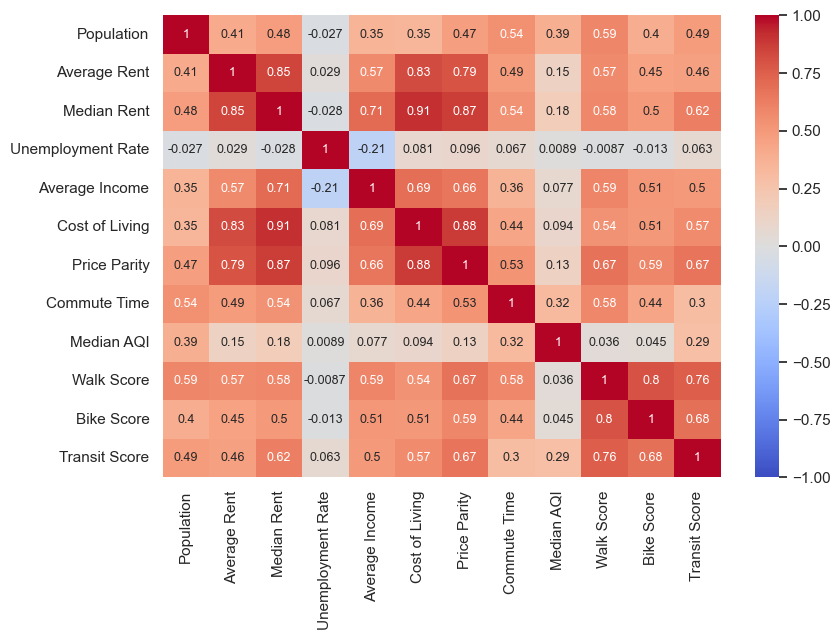

In [31]:
# Full names of variables for better readability
columns_full_names = ['Population', 'Average Rent', 'Median Rent', 'Unemployment Rate', 'Average Income', 
                      'Cost of Living', 'Price Parity', 'Commute Time', 'Median AQI', 'Walk Score', 'Bike Score', 'Transit Score']

# Set theme for all the future graphs
sns.set_theme(style="white", rc={'figure.figsize':(9,6)})

sns.heatmap(cities.corr(), cmap="coolwarm", annot=True, vmin=-1, vmax=1, annot_kws={"size": 9}, xticklabels=columns_full_names, yticklabels=columns_full_names)
plt.show()

From this map, we can see that:

* There is a number of quite obvious observations. High cost of living is accompanied by high rental prices and high incomes (and vice versa). It makes sense since rental prices contribute a lot to cost of living. Also, cities with good walkability are good at public transportation and bike construction.
* Another obvious observations is that cities with high population are on average more expensive, they have higher incomes and worse air quality.
* A correlation between air quality (<i>note that this is the only metric where the higher means the worse</i>) and commute time can indicate either  that air quality is affected by traffic congestion and transportation emissions or that both parameters a caused by high population.
* Unemployment rate has near-zero correlation with all the other variables. But the only significant correlation is with Average Incomes, meaning that higher unemployment rates tend to have lower average incomes.
* Median Rent has stronger correlation with other factors than Average Rent, meaning it could be a more significant factor in determining a city’s livibility.

### Summary Statistics by Size

Use the df.describe() method to get summary statistics about the DataFrame. But to better understand the situation, it's better to break down our table into three by size of metropolitan area.

In [32]:
##### Summary statistics for big cities
large_cities = cities.loc[cities.Size == 'Large']
large_cities.describe()

,Population,AvgRent,MedianRent,UnempRate,AvgIncome,CostOfLiving,PriceParity,CommuteTime,MedianAQI,WalkScore,BikeScore,TransitScore
count,5.600000e+01,56.000000,56.000000,55.000000,56.00000,55.000000,56.000000,56.000000,56.000000,51.000000,51.000000,56.000000
mean,3.377466e+06,1833.964286,1376.803571,3.040000,67278.37500,105.452727,100.760893,26.883929,48.321429,52.929412,54.570588,3.801786
std,3.296962e+06,608.939554,467.829472,0.783771,15070.67341,18.644450,7.328437,3.494764,9.309052,16.642335,12.757355,1.514475
min,1.008654e+06,1130.000000,830.000000,1.900000,50384.00000,86.700000,90.620000,21.200000,29.000000,25.600000,30.700000,0.100000
25%,1.394931e+06,1382.000000,1020.500000,2.550000,58955.25000,93.450000,95.435000,24.475000,44.000000,41.150000,43.900000,2.600000
50%,2.274416e+06,1717.000000,1287.500000,2.900000,64239.00000,100.100000,98.850000,26.450000,46.000000,49.500000,54.000000,3.600000
75%,4.112082e+06,1979.000000,1533.750000,3.400000,70710.50000,108.550000,105.382500,29.000000,51.000000,65.700000,64.850000,5.025000
max,2.014047e+07,3422.000000,3000.000000,6.200000,136338.00000,178.600000,119.830000,36.700000,84.000000,88.700000,83.500000,6.900000


##### Summary statistics for middle-sized cities

In [33]:
# Summary statistics for mid-sized cities
mid_cities = cities.loc[cities.Size == 'Mid-Sized']
mid_cities.describe()

,Population,AvgRent,MedianRent,UnempRate,AvgIncome,CostOfLiving,PriceParity,CommuteTime,MedianAQI,WalkScore,BikeScore,TransitScore
count,129.000000,129.000000,129.000000,125.000000,129.000000,122.000000,129.000000,126.000000,129.000000,23.000000,23.000000,129.000000
mean,503160.472868,1521.248062,1068.031008,3.446400,57256.813953,97.607377,95.566589,23.334921,41.193798,38.365217,45.047826,2.334884
std,206013.220412,479.419620,342.103236,1.329294,12252.266043,13.052837,5.534128,2.894141,6.788176,7.553904,8.968828,1.124490
min,256728.000000,781.000000,663.000000,1.600000,34503.000000,83.900000,85.880000,17.300000,18.000000,21.400000,29.700000,0.400000
25%,328883.000000,1217.000000,854.000000,2.500000,50616.000000,88.625000,91.870000,21.425000,39.000000,33.250000,40.300000,1.500000
50%,433353.000000,1420.000000,959.000000,3.100000,54623.000000,93.250000,93.960000,22.900000,42.000000,39.100000,43.700000,2.100000
75%,649903.000000,1784.000000,1188.000000,3.900000,61547.000000,102.075000,98.960000,24.800000,44.000000,43.900000,51.900000,3.000000
max,978529.000000,3350.000000,2602.000000,8.800000,127391.000000,163.900000,111.810000,33.300000,67.000000,49.700000,65.500000,5.100000


In [34]:
# Summary statistics for small cities
small_cities = cities.loc[cities.Size == 'Small']
small_cities.describe()

,Population,AvgRent,MedianRent,UnempRate,AvgIncome,CostOfLiving,PriceParity,CommuteTime,MedianAQI,WalkScore,BikeScore,TransitScore
count,159.000000,159.000000,153.000000,155.000000,159.000000,158.000000,158.000000,107.00000,117.000000,0.0,0.0,159.000000
mean,152830.031447,1350.805031,903.183007,3.329032,53693.761006,93.772785,92.706582,21.31215,37.324786,NaN,NaN,1.508805
std,44979.209688,405.689107,192.709334,1.368807,9761.348362,8.804079,4.695104,3.61012,8.521604,NaN,NaN,1.104042
min,58639.000000,657.000000,648.000000,1.700000,41012.000000,82.600000,85.480000,15.70000,10.000000,NaN,NaN,0.000000
25%,121836.500000,1057.000000,772.000000,2.400000,47868.000000,88.025000,89.232500,19.00000,36.000000,NaN,NaN,0.700000
50%,150309.000000,1293.000000,852.000000,3.100000,51965.000000,91.050000,92.025000,20.70000,39.000000,NaN,NaN,1.400000
75%,181630.000000,1590.000000,1011.000000,3.850000,56899.000000,97.275000,94.875000,23.45000,42.000000,NaN,NaN,2.300000
max,249843.000000,2898.000000,1959.000000,13.700000,125455.000000,149.600000,112.070000,39.40000,67.000000,NaN,NaN,4.700000


From tables above, we can see that regional price parity in cities with population more than one million is almost equal to the national average of 100. Meanwhile, living cost in mid-sized and small cities is 95.6% and 92.7% of the U.S. average. <br>
Just as we saw on the heat map, larger cities have worse air quality and longer commutes, but have higher incomes and and better transportation.

# Analyze Data
Visulize some of the variables to spot patterns and test them.<br>

In the section below, I cover on only a fragment of what can be visualized and tested in this file, as the possibilities of that are endless. I focus on some of the variables I found the most interesting.

### Commute Time vs Transit Score by Size
The heatmap shows some correlation (0.3) between the median commute time and the transit score. It doesn't necessarily means that the better the public transportation in a city, the longer it takes to get to work, but this correlation seems counterintuitive. Let's explore it further by plotting it and using the price parity and size as third and forth variables.<br>
The hypothesis is that both longer commutes and good public transportation are attributes of large cities with high costs of living.

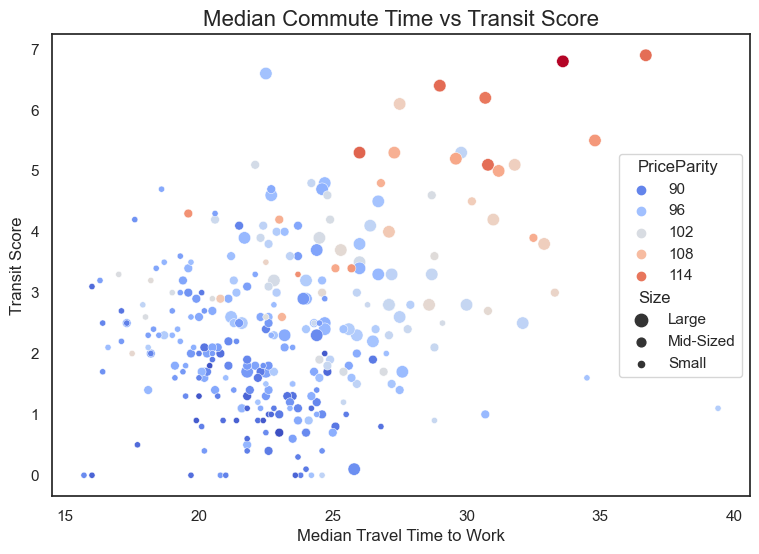

In [35]:
palette = sns.color_palette("coolwarm", as_cmap=True)
sns.scatterplot(data=cities, x='CommuteTime', y='TransitScore', hue='PriceParity', palette=palette, 
                size='Size', size_order=['Large', 'Mid-Sized', 'Small'], sizes=[80, 40, 20])
plt.title('Median Commute Time vs Transit Score', fontsize=16)
plt.xlabel('Median Travel Time to Work')
plt.ylabel('Transit Score')
plt.show()

The larger and more expensive cities occupy the upper-right corner of the graph.

### Average Income and Rent by Size and Region

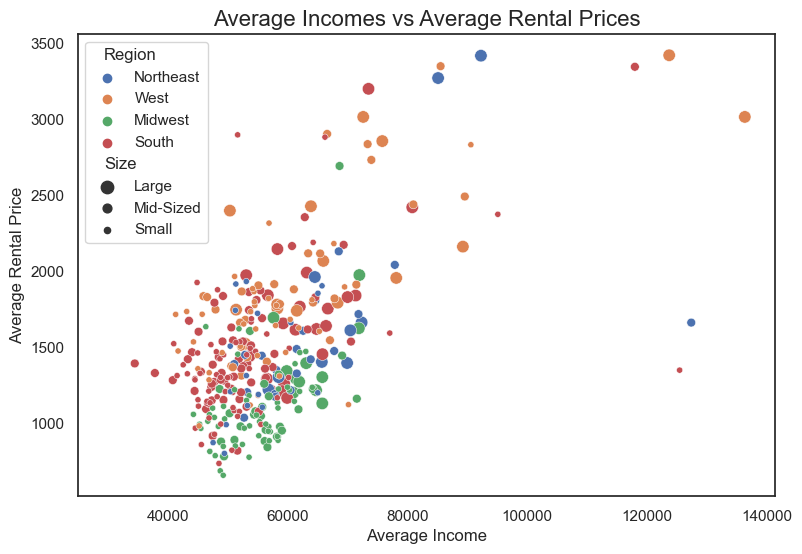

In [37]:
ax = sns.scatterplot(data=cities, x='AvgIncome', y='AvgRent', hue='Region', 
                size='Size', size_order=['Large', 'Mid-Sized', 'Small'], sizes=[80, 40, 20])
ax.set_xlim(left=25000)
plt.title('Average Incomes vs Average Rental Prices', fontsize=16)
plt.xlabel('Average Income')
plt.ylabel('Average Rental Price')
plt.show()

### Median Rental Prices by Region and Size


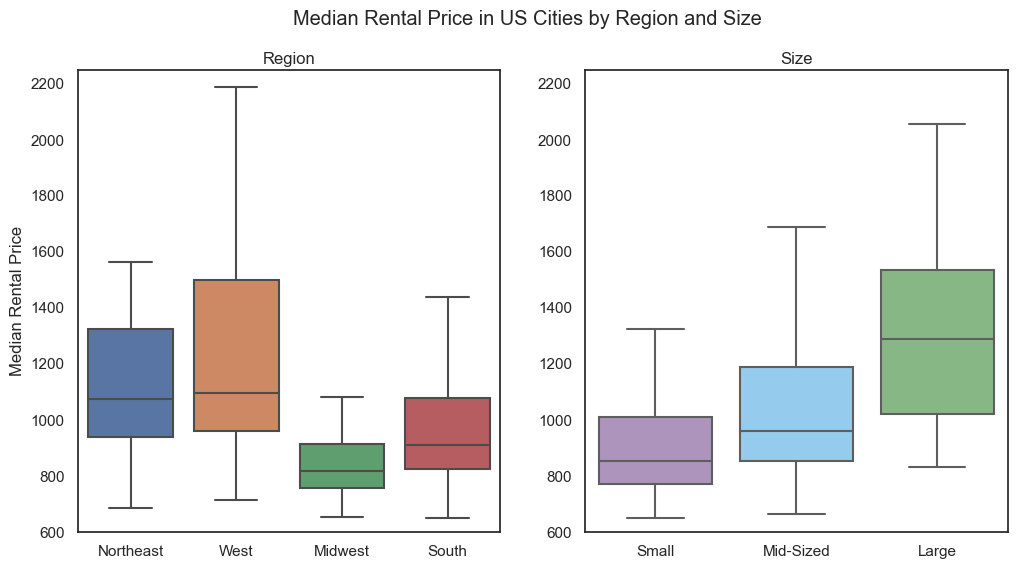

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.set_ylim(600, 2250)
sns.boxplot(y='MedianRent', x='Region', data=cities, ax=ax1, showfliers=False)
ax1.set_ylabel('Median Rental Price')
ax1.xaxis.set_label_position('top') 

ax2.set_ylim(600, 2250)
sns.boxplot(y='MedianRent', x='Size', data=cities, ax=ax2, showfliers=False, palette=['#af8dc3', '#87CEFA', '#7fbf7b'])
ax2.set_ylabel('')
ax2.xaxis.set_label_position('top') 

fig.suptitle('Median Rental Price in US Cities by Region and Size')
plt.show()

### Commute Times by Region and Size

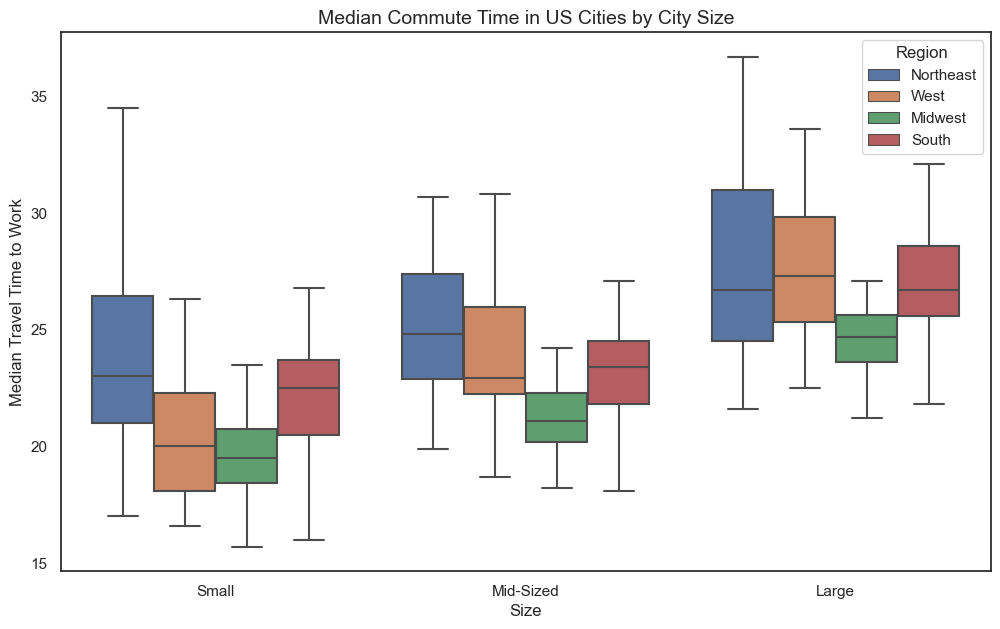

In [39]:
fig = plt.figure(figsize=(12, 7))

sns.boxplot(y='CommuteTime', x='Size', hue='Region', data=cities, showfliers=False)

plt.ylabel('Median Travel Time to Work')
plt.title('Median Commute Time in US Cities by City Size', fontsize=14)
plt.show()

### Unemployment Rate by Region and Size

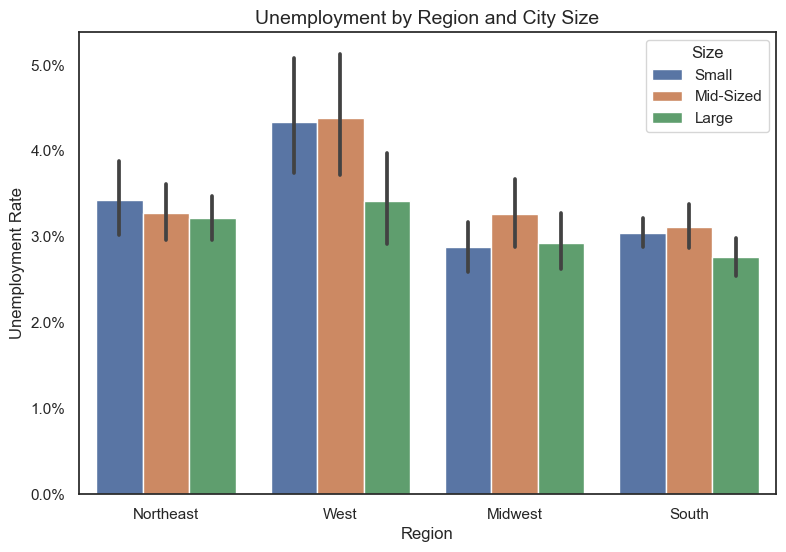

In [40]:
# To show percetage
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

with sns.axes_style("whitegrid"):
    sns.barplot(y='UnempRate', x='Region', hue='Size', data=cities)
    ax.set_ylabel('Unemployment Rate')

plt.title('Unemployment by Region and City Size', fontsize=14)
plt.show()

### Median AQI by Size

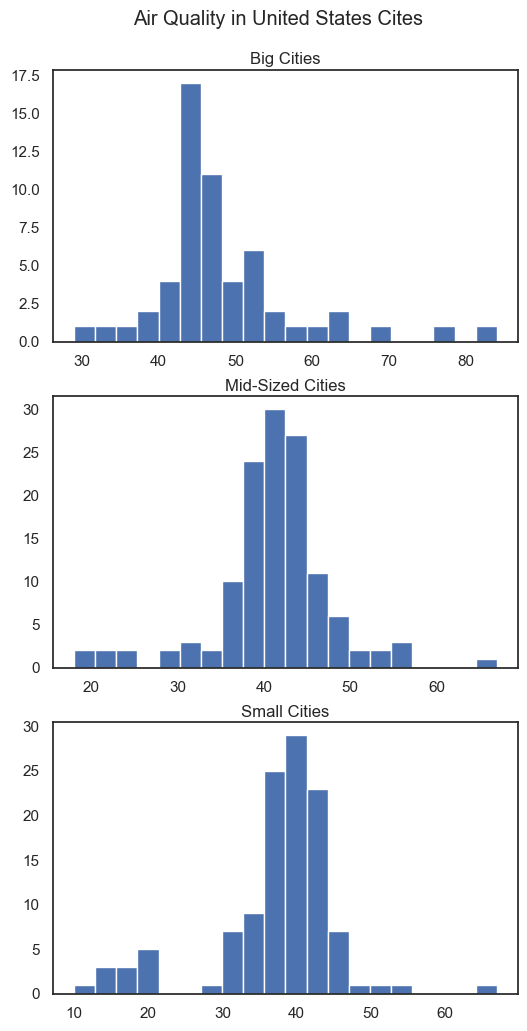

In [41]:
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

axs[0].hist(large_cities['MedianAQI'], bins=20)
axs[1].hist(mid_cities['MedianAQI'], bins=20)
axs[2].hist(small_cities['MedianAQI'], bins=20)

axs[0].set_xlabel('Big Cities')
axs[0].xaxis.set_label_position('top')
axs[1].set_xlabel('Mid-Sized Cities')
axs[1].xaxis.set_label_position('top')
axs[2].set_xlabel('Small Cities')
axs[2].xaxis.set_label_position('top')

fig.suptitle('Air Quality in United States Cites', y=0.93)

plt.show()